# Comparison of NASA Land Information System (LIS) water balance simulations and GRACE mascon data for HMA

This is a direct comparison of LIS-derived cumulative water balances with the published GRACE mascon product (fully processed, iterated solution without removal of terrestrial water storage). We are comparing monthly products over the prototyping region of the Upper Indus Basin.

Refinements needed:

* LIS data are grouped by calendar month whereas GRACE is approximately monthly but varies. Need to match LIS temporal aggregation to GRACE time stamps
* Water balances should be calculated as in Swenson and Wahr (2006), since GRACE does not provide mass estimates at discrete points in time as a conventional water balance model provides

By Anthony Arendt and Landung Setiawan

## Workflow to get here:

1. Run [waterBalance.ipynb](../LIS/waterBalance.ipynb): pre-processes LIS output to read daily NetCDF files, combine into a single xarray dataset, and aggregate into monthly values. 
2. Run [GRACE_LandInformationSystem.ipynb](GRACE_LandInformationSystem.ipynb): generate a mask compatible with xarray so we can leverage its spatial groupby capabilities; apply the mask to the monthly LIS data, thereby performing necessary spatial aggregation to 1x1 degree equal area mascons.

In [29]:
# Jupter notebook magic
%matplotlib inline

# Import libraries to work with the data
import os
import sys
from datetime import datetime, timedelta

import geopandas as gpd
from geopandas import GeoDataFrame

import h5py
import numpy as np
import pandas as pd
import scipy.optimize
from PyAstronomy import pyasl
from scipy import signal
import matplotlib
from shapely.geometry import (Polygon, Point, box)
from PyAstronomy import pyasl

from himatpy.GRACE_MASCON.pygrace import (extract_grace, get_mascon_gdf, trend_analysis, get_cmwe_trend_analysis)
from himatpy.LIS import utils as LISutils

import pickle
import matplotlib.pyplot as plt

import warnings
warnings.filterwarnings('ignore')

In [2]:
gracedat = '../../files/GRACE/GSFC.glb.200301_201607_v02.3b-ICE6G.h5'
lisdat = '../../files/LIS/LIS_by_mascon.pkl'

## Read in the GRACE data

In [3]:
g = extract_grace(gracedat)

Data extracted: 
---
Group: mascon
---
<HDF5 dataset "area_deg": shape (1, 41168), type "<f8">
<HDF5 dataset "area_km2": shape (1, 41168), type "<f8">
<HDF5 dataset "basin": shape (1, 41168), type "<f8">
<HDF5 dataset "elev_flag": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lat_span": shape (1, 41168), type "<f8">
<HDF5 dataset "location": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_center": shape (1, 41168), type "<f8">
<HDF5 dataset "lon_span": shape (1, 41168), type "<f8">
---
Group: size
---
<HDF5 dataset "N_arcs": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascon_times": shape (1, 1), type "<f8">
<HDF5 dataset "N_mascons": shape (1, 1), type "<f8">
---
Group: solution
---
<HDF5 dataset "cmwe": shape (41168, 148), type "<f8">
<HDF5 dataset "uncertainty": shape (41168, 148), type "<f8">
---
Group: time
---
<HDF5 dataset "list_ref_days_solution": shape (1, 4128), type "<f8">
<HDF5 dataset "n_ref_days_solution": shape (1,

In [4]:
mascon = g['mascon']
soln = g['solution']
mascon_gdf = get_mascon_gdf(mascon)
## we need to track mascon numbers later, which we get from the index, so make a new "mascon" column
mascon_gdf['mascon'] = mascon_gdf.index

There are 41168 Mascons in this dataset.


## Get LIS dataframe from pickle

In [80]:
# dropping mask, not needed for graph
lisdf = pickle.load(open(lisdat, 'rb')).reset_index(drop=True, level=0)

In [6]:
# unique mascon id's for region
masconsid = lisdf['mascon'].unique()

In [7]:
lisdf.head()

,Qsm_tavg,Rainf_tavg,Qs_tavg,Snowf_tavg,Qsb_tavg,Evap_tavg,TWS_tavg,mascon,waterbal,waterbal_cumulative
time,,,,,,,,,,
2001-01-01,0.0,0.005750,0.000105,6.288375e-05,0.637697,6.497751,155973.542914,8119,-7.129635,-7.129635
2001-02-01,0.0,1.572855,0.025225,1.608942e-05,0.588437,4.668368,145432.582280,8119,-3.683934,-10.813569
2001-03-01,0.0,2.158684,0.034859,3.358837e-17,0.643275,5.312384,160911.182782,8119,-3.796974,-14.610543
2001-04-01,0.0,40.241033,0.591367,0.000000e+00,0.614738,22.778068,155926.765992,8119,16.848226,2.237683
2001-05-01,0.0,0.529290,0.007452,0.000000e+00,0.631675,9.491286,161194.044970,8119,-9.593671,-7.355988


## get the GRACE time series data

In [8]:
t = pd.DataFrame(data = {
    'time': g['time']["ref_days_middle"][0,:]
})

### convert from cm to mm water equivalent; convert time from decimal year to datetime

In [9]:
grc_lst = []
for m in masconsid:
    df = pd.DataFrame(data={
        'mmwe': soln['cmwe'][m][:] * 10,
        'mascon': m
    })
    df.index = t['time'].apply(lambda x: datetime(2001,12,31) + timedelta(days=x))
    grc_lst.append(df)

In [10]:
gracedf = pd.concat(grc_lst)

In [11]:
gracedf.head()

,mascon,mmwe
time,,
2003-01-06 12:00:00,8119,-35.208430
2003-02-21 00:00:00,8119,-2.004382
2003-03-16 00:00:00,8119,5.896959
2003-04-15 12:00:00,8119,-42.092590
2003-05-07 12:00:00,8119,-21.614554


## Perform analysis (Single mascon for testing)

In [12]:
masconid = 8064

In [13]:
lisdf.head()

,Qsm_tavg,Rainf_tavg,Qs_tavg,Snowf_tavg,Qsb_tavg,Evap_tavg,TWS_tavg,mascon,waterbal,waterbal_cumulative
time,,,,,,,,,,
2001-01-01,0.0,0.005750,0.000105,6.288375e-05,0.637697,6.497751,155973.542914,8119,-7.129635,-7.129635
2001-02-01,0.0,1.572855,0.025225,1.608942e-05,0.588437,4.668368,145432.582280,8119,-3.683934,-10.813569
2001-03-01,0.0,2.158684,0.034859,3.358837e-17,0.643275,5.312384,160911.182782,8119,-3.796974,-14.610543
2001-04-01,0.0,40.241033,0.591367,0.000000e+00,0.614738,22.778068,155926.765992,8119,16.848226,2.237683
2001-05-01,0.0,0.529290,0.007452,0.000000e+00,0.631675,9.491286,161194.044970,8119,-9.593671,-7.355988


### A possible way to do multipanel subplots of individual mascons

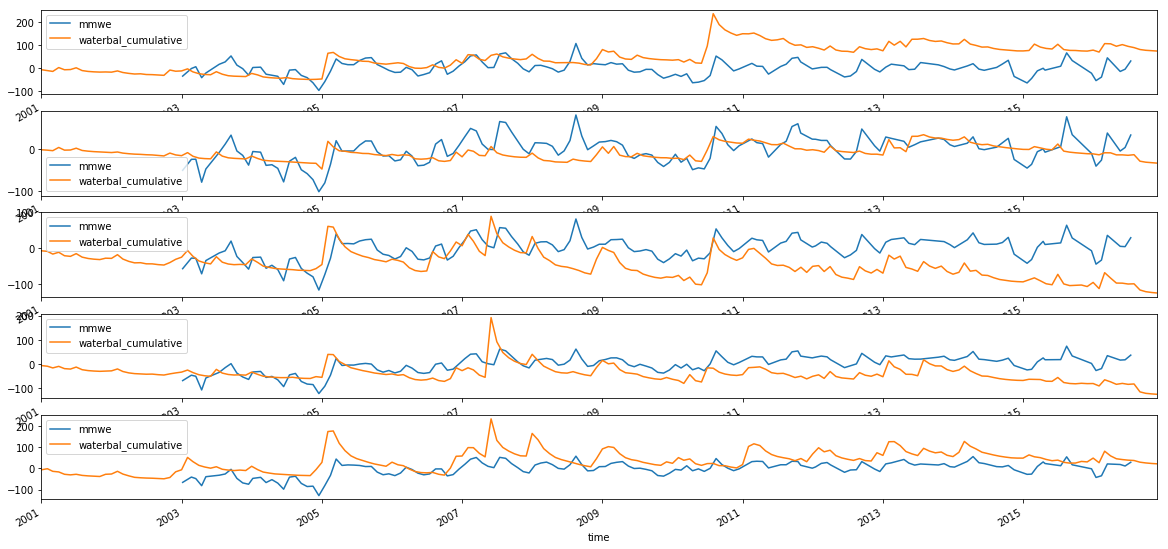

In [14]:
f, ax = plt.subplots(nrows=5, figsize=(20, 10))

for idx, masconid in enumerate(masconsid[:5]):
    # GRACE
    (gracedf[gracedf['mascon'] == masconid]).plot(ax=ax[idx], y='mmwe')

    # LIS
    (lisdf[lisdf['mascon'] == masconid]).plot(ax=ax[idx], y='waterbal_cumulative')

### Plots of individual mascons for testing

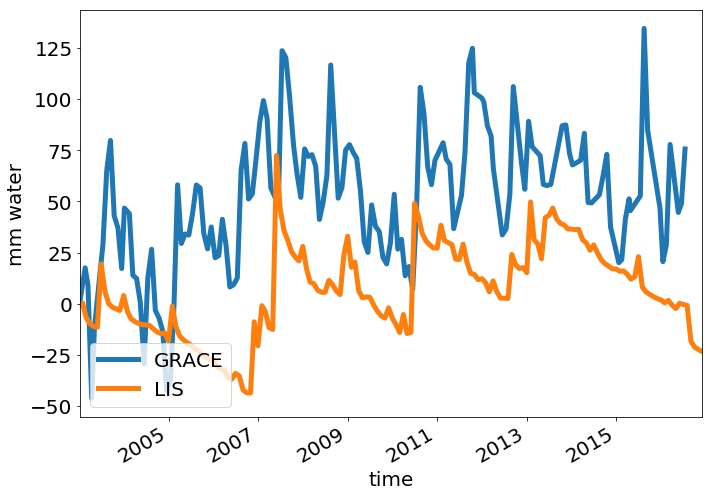

In [15]:
#masconid = 8064 # Karakoram, glacier dominated
#masconid = 8081 # alpine, but no ice
masconid = 8129 # lower in the watershed
GRACE_offset = gracedf[gracedf['mascon'] == masconid].iloc[0].mmwe
ax1 = (gracedf[gracedf['mascon'] == masconid] - GRACE_offset).plot(y='mmwe', label = 'GRACE',figsize=(10,7), linewidth = 5)
LIS_offset = lisdf[lisdf['mascon'] == masconid].loc[gracedf.iloc[0].name:].iloc[0].waterbal_cumulative
(lisdf[lisdf['mascon'] == masconid].loc[gracedf.iloc[0].name:] - LIS_offset).plot(ax=ax1, y='waterbal_cumulative', label = 'LIS', fontsize = 20, linewidth = 5)
plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.legend(fontsize = 20, loc = 3)
plt.tight_layout()
plt.savefig('c:\\temp\\8081.png', dpi=300, transparent = True, frameon = True, pad_inches = 0)

In [16]:
grc_all = gracedf

grct = grc_all.groupby('time').mean()

wctst = lisdf.groupby('time').mean()
# clip to the same time period as GRACE
wctst = wctst.loc[grct.iloc[0].name:]

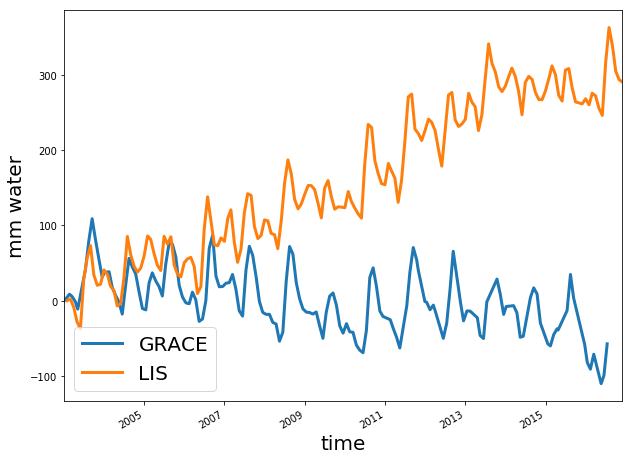

In [17]:
f, ax = plt.subplots(1, figsize=(10, 8))
(grct - grct.iloc[0].mmwe).plot(ax=ax, y='mmwe', linewidth = 3)
(wctst - wctst.iloc[0].waterbal_cumulative).plot(ax=ax, y='waterbal_cumulative', linewidth = 3)

plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
ax.legend(['GRACE','LIS'],fontsize = 20, loc = 3)
font = {'family' : 'Times',
        'size'   : 16}
matplotlib.rc('font', **font)

plt.savefig('c:\\temp\\all.png', dpi=300, transparent = True)

## Mean water balance over the entire Upper Indus Basin, linear trend removed

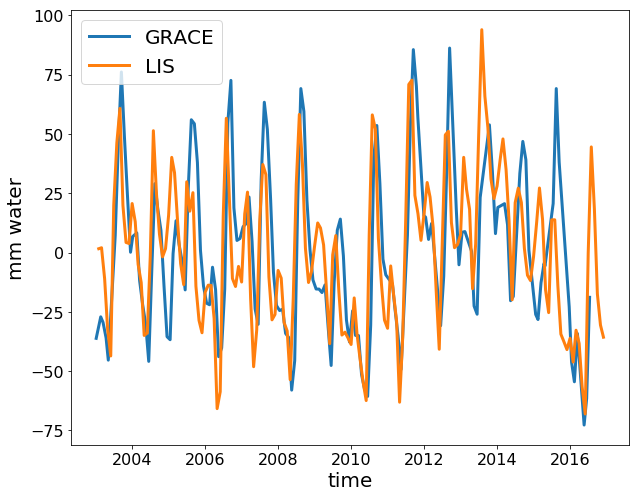

In [18]:
# detrending the LIS data

LIS_mass = wctst.waterbal_cumulative.values
LIS_decyear = pd.Series(wctst.index).apply(lambda x: pyasl.decimalYear(x))

# detrending the GRACE data

GRACE_mass = grct.mmwe.values
GRACE_decyear = g['time']['yyyy_doy_yrplot_middle'][2, :]

# plot GRACE and LIS together
plt.figure(figsize=(10,8))
plt.plot(GRACE_decyear,signal.detrend(GRACE_mass, type = 'linear'),LIS_decyear,signal.detrend(LIS_mass, type = 'linear'),linewidth = 3)
plt.ylabel('mm water', fontsize = 20)
plt.xlabel('time', fontsize = 20)
plt.legend(['GRACE','LIS'],fontsize = 20, loc = 2)

font = {'family' : 'Times',
        'size'   : 16}

matplotlib.rc('font', **font)
plt.savefig('c:\\temp\\allDetrended.png', dpi=300, transparent = True)

In [24]:
world = gpd.read_file(gpd.datasets.get_path('naturalearth_lowres'))
coordinates = [(62,26), (62,46), (106,46), (106, 26)]
# Create a Shapely polygon from the coordinate-tuple list
poly = Polygon(coordinates)
# create a geodataframe
HMA_region = gpd.GeoDataFrame()
HMA_region.loc[0, 'geometry'] = poly

### Data Visualization

In [26]:
HMA = mascon_gdf[(mascon_gdf['location'] == 80.0) & ((mascon_gdf['basin'] > 5000.0) & (mascon_gdf['basin'] < 6100.0))]

In [30]:
HMA_w_trend = get_cmwe_trend_analysis(HMA, g)

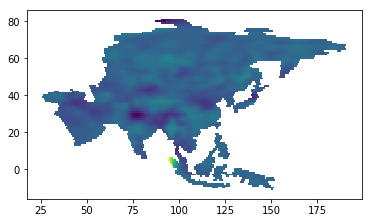

In [31]:
HMA_w_trend.plot(column='avg_mass_change_cm')

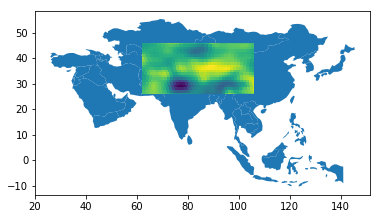

In [36]:
gpd_intersect = gpd.overlay(HMA_region, HMA_w_trend, how='intersection')
gpd_intersect.plot(column='avg_mass_change_cm', ax=world[world['continent'] == 'Asia'].plot(), figsize=(20, 20))

In [99]:
#decyr = lisdf[lisdf['mascon'] == 8119].reset_index()['time'].apply(lambda x: pyasl.decimalYear(x))
#t = lisdf.reset_index().merge(HMA, on='mascon', how='inner')[['waterbal_cumulative','mascon','time','geometry']]

In [3]:
listdf.groupby('mascon').apply(lambda x: trend_analysis(x['time'].apply(lambda x: pyasl.decimalYear(x)), 
                                                   x['waterbal_cumulative'], optimization = True)[1] )